![title](./images/logo_nao_digital.png)

# Tema 3. Conocimientos sobre librerías de visualización estática

## 1. Objetivo

Para enriquecer el análisis de Oilst y hacerlo más accesible al público no especializado, el equipo de `Brasil BI Consulting` decidió crear visualizaciones estáticas, es decir sin animaciones o filtros interactivos, a partir de los datos de las órdenes de los clientes.

Con ello en mente, el objetivo de la presente sección será trabajar con la librería `Seaborn` de Python (https://seaborn.pydata.org) para abundar en el análisis correspondiente. Seaborn es una librería para implementar gráficos estadísticos en Python, que se basa en `matplotlib` y se integra estrechamente con las estructuras de datos de `pandas`.

## 2. Librerias de trabajo

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Libreria de visualización
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## 3. Lectura de datos

Leeremos primeros los datos del e-commerce que procesamos previamente en Pandas.

In [4]:
# Primero indicamos la ruta a la carpeta de de tu computadora 
# donde se ubican los datos procesados del E-commerce
# Ejemplo: "C:\Usuarios\[tu nombre]\Descargas"

DATA_PATH="C:\\Users\\Natalia\\Recursos DN_COM_58"

In [5]:
FILE_CONSOLIDATED_DATA = 'oilst_processed.csv'

Recordemos que algunas de las columnas que contienen fechas deben ser convertidas al formato correspondiente, lo cual se puede llevar a cabo de forma automática usando el parámetro de `parse_dates`:

In [6]:
columns_dates=[
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
    ]

oilst = pd.read_csv(
    os.path.join(DATA_PATH, FILE_CONSOLIDATED_DATA),
    parse_dates=columns_dates
    )

La información general de esta tabla la podemos obtener, como ya sabemos, a través del comando `.info`

In [7]:
oilst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   distance_distribution_center   96470 non-null  float64       
 9   year                           99441 non-null  int64         
 10  month                          99441 non-null  int64         
 11  quarter        

También definiremos un dataframe que contiene únicamente a las órdenes que tienen estatus de entrega completada, es decir, que satisfacen con la condición de que la columna `order_status` es igual al valor `delivered`.

In [8]:
delivered = oilst.query("order_status == 'delivered'")

## 4. Análisis univariado

Seaborn es una librería de visualización de datos de Python basada en matplotlib, contando entre sus ventajas 
la facilidad de uso y personalización, una cantidad considerable de visualizaciones disponibles y la posibildad de tomar como datos de entradas a dataframes de Pandas.


### 4.1 Análisis de diferencia entre tiempo de entrega real y estimado

Para comenzar, podemos explorar nuevamente la variable **delta_days**, que como sabemos es la diferencia entre el tiempo estimado de la entrega y cuando se llevó a cabo la entrega realmente, reportándose en días. Es importante recalcar que:

* Si `delta_days <= 0`, significa que el pedido llegó que no hubo atraso en la entrega,
* Si `0 < delta_days < 3`, ello refiere que el pedido se entregó en un intervalo de tiempo moderado, que es aceptable de acuerdo a las políticas de negocio de `Olist`,
* Mientras que si  `delta_days > 3`, ello denota que existe un retraso que ya no se considera aceptable.

#### 4.1.1 Histogramas de frequencias y función de distribución acumulativa empírica

Como se ha calculo previamente, la diferencia entre tiempo de entrega real y estimado es en promedio de `-11 días`, es decir, en general los envíos suelen llegar antes de lo esperado.

In [9]:
print("Promedio de la diferencia de tiempo de estimado entrega y real: ", round(delivered["delta_days"].mean(),2), ' días')

Promedio de la diferencia de tiempo de estimado entrega y real:  -11.18  días


Ello se puede constatar empleando el concepto estadístico de **percentiles**, el cual se refiere es una forma de medir la posición de un valor en un conjunto de datos. Imagina que tienes un conjunto de datos, por ejemplo, las alturas de un grupo de personas. Si ordenas estas alturas de menor a mayor, el percentil te dirá en qué posición se encuentra una altura en particular de una persona con las alturas del resto de las demás.

Por ejemplo, si la altura de una persona se encuentra en el percentil 75, significa que su altura es mayor que el 75% de las alturas en el conjunto de datos. De manera similar, si la altura de una persona se encuentra en el percentil 25, significa que su altura es mayor que el 25% de las alturas en el conjunto de datos.

En Pandas, estos se pueden calcular con usando la utilidad `.describe` y una lista que indica las posiciones en su variables `percentiles`.

Con ello en mente, podemos notar que la mayoría de los datos, hasta el percentil que corresponde al 90%, tiene un valor `delta_days` en un tiempo es un valor negativo (`-1.14 días`). Es decir, se entregan en su mayoría antes del tiempo que se les comunica a los clientes:

In [10]:
# Lista de percentiles a calculas (desde el 10%, 20%, ..., 90% y 100% )
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9,1]

# Calculo de percentoles
delivered[["delta_days"]].describe(
    percentiles=percentiles
    ).round(2)

,delta_days
count,96470.00
mean,-11.18
std,10.18
min,-146.02
10%,-21.29
20%,-17.77
30%,-15.12
40%,-13.24
50%,-11.95
60%,-9.48


Para apreciar de mejor forma esta distribución, podemos acudir al concepto de **histograma de frecuencias**, el cual es una herramienta gráfica que muestra cuantas veces ocurren las diferentes valores en un conjunto de datos. En otras palabras, representa cuántas veces aparece cada valor en el conjunto de datos. Éste se puede representar de manera gráfica con barras que muestran la frecuencia con la que aparece cada uno de los valores que típicamente se agrupan en intervalos para facilitar el conteo (`bins`, en inglés).

 Un histograma puede ayudarnos a identificar patrones en la distribución de los datos, como si las notas están concentradas en un rango estrecho o si están más dispersas.

En seaborn, se puede obtener usando la función `histplot`, especificando la cantidad de particiones en lo que se agruparán los datos para su contabilización (`bins`).

[Text(0.5, 1.0, 'Fig. 1 Histograma de frecuencias de `delta_days`')]

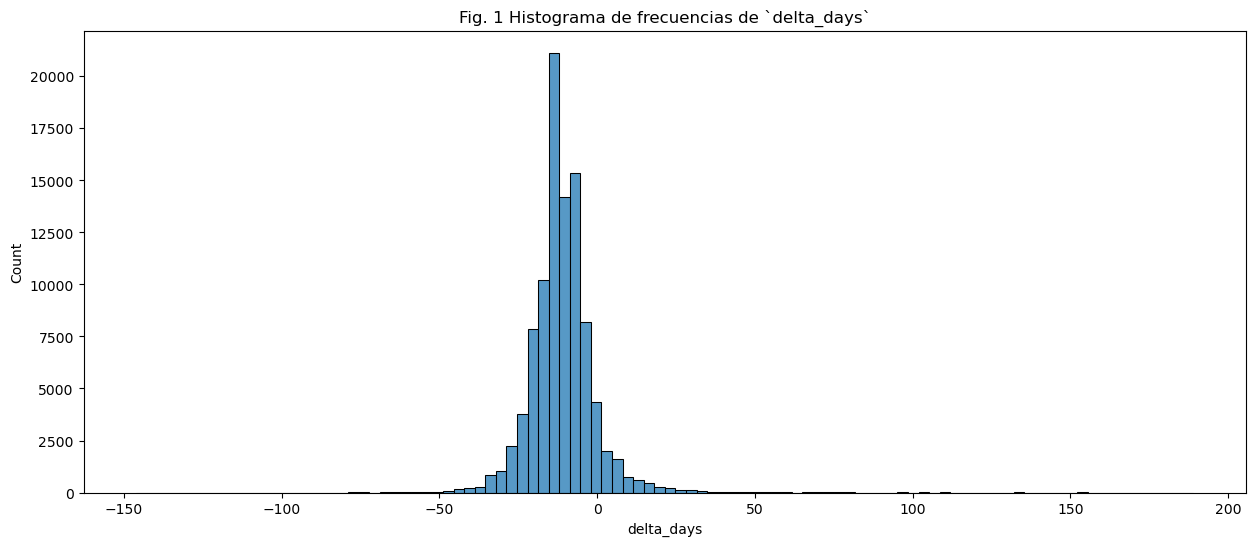

In [11]:
# Especifica el tamaño de la figura
plt.figure(figsize = (15,6))

sns.histplot(
    data=delivered["delta_days"],
    bins=100
    ).set(
        title='Fig. 1 Histograma de frecuencias de `delta_days`'
        )

**Nota:** En este caso, la función `histplot` se ha alimentado directamente de la columna `delivered["delta_days"]` del dataframe de Pandas en donde leímos los datos.

Como se aprecia, la diferencia de tiempo de estimado entrega y real tienen un distribución sesgada a la izquierda, hacia valores negativos, lo que concuerda con la idea de que casi todos los pedidos llegan antes de lo previsto.

Para ilustrarlo mejor, en la figura de abajo, se añade el valor promedio de la diferencia de tiempo de estimado entrega y real:

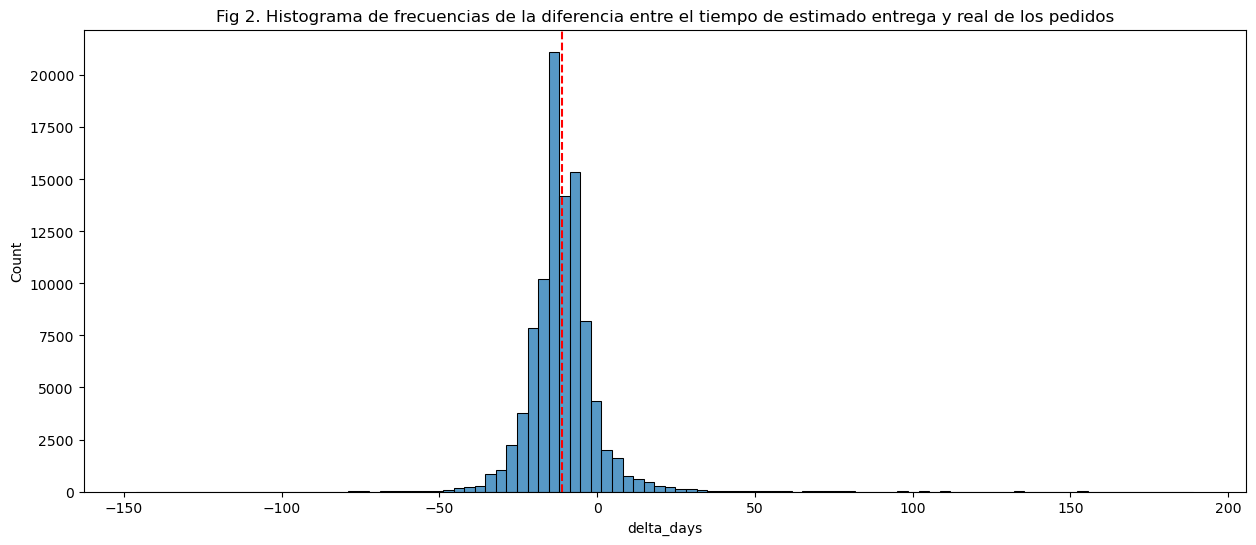

In [12]:
# Especifica el tamaño de la figura
plt.figure(figsize = (15,6))

# Crea al histograma
sns.histplot(
    data=delivered["delta_days"],
    bins=100
    ).set(title='Fig 2. Histograma de frecuencias de la diferencia entre el tiempo de estimado entrega y real de los pedidos')

# Agrega el promedio de la variable en estudio
plt.axvline(
    x=delivered["delta_days"].mean(), # p
    color='red',
    ls='--', 
    lw=1.5
    )

**Notas:** 1) En la figura se ha añadido el título usando la función `.set(title= '... texto ...')`, 2) además el promedio se ha dibujando echando mano de la función `axvline` de matplotlib, que como sabemos es la librería base con la que está construida Seaborn.

## 7. Entregables

En esta sección los entregables consisten en un script en Python junto con un imagen en un archivo en formato específico:

A. Script que construya una visualización que permita comparar los histogramas de las ventas de órdenes completas que tuvieron retrazos moderados y prolongados. Este script tendrá el nombre `3_a_histogram_sales_short_long_delays.py` y la imagen resultante deberá denominarse `3_a_histogram_sales_short_long_delays.png`.


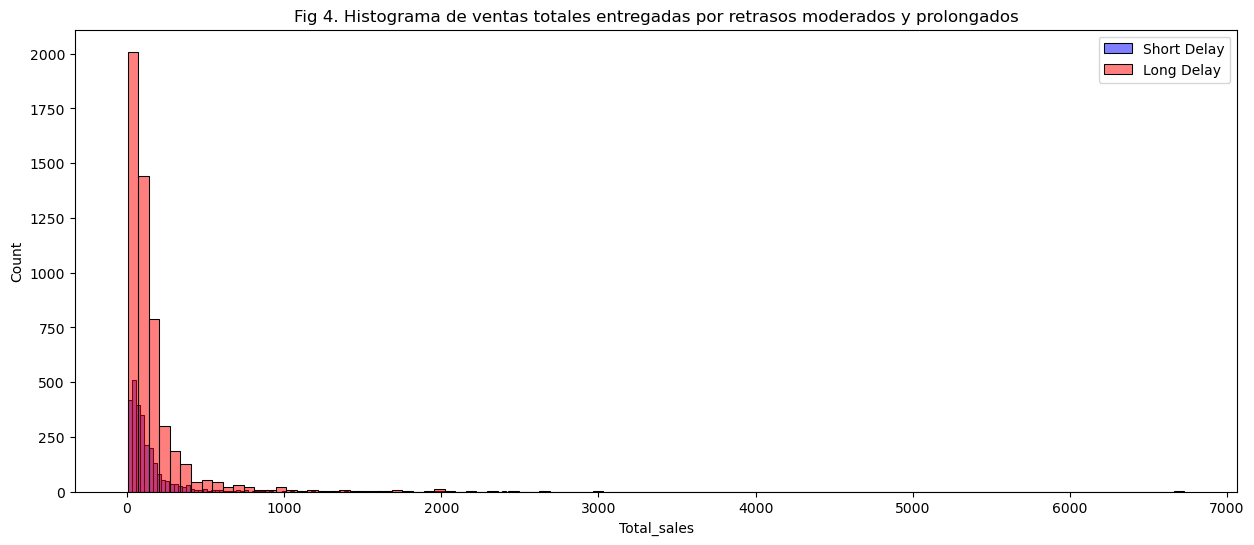

In [13]:
# Visualización que permite comparar los histogramas de las ventas de órdenes completas que tuvieron retrazos moderados y prolongados

# Especifica el tamaño de la figura
plt.figure(figsize = (15, 6))

# Filtra el DataFrame para órdenes con retrasos moderados
retraso_moderado = delivered[delivered['delay_status'] == 'short_delay']

# Filtra el DataFrame para órdenes con retrasos prolongados
retraso_prolongado = delivered[delivered['delay_status'] == 'long_delay']

# Crea el histograma para órdenes con retrasos moderados
sns.histplot(retraso_moderado['total_sales'], bins=100, alpha=0.5, label='Short Delay', color='blue')

# Crea el histograma para órdenes con retrasos prolongados
sns.histplot(retraso_prolongado['total_sales'], bins=100, alpha=0.5, label='Long Delay', color='red')

# Agrega etiquetas y título
plt.xlabel('Total_sales')
plt.ylabel('Count')
plt.title('Fig 4. Histograma de ventas totales entregadas por retrasos moderados y prolongados')

# Agrega una leyenda
plt.legend()

# Muestra el gráfico
plt.show()


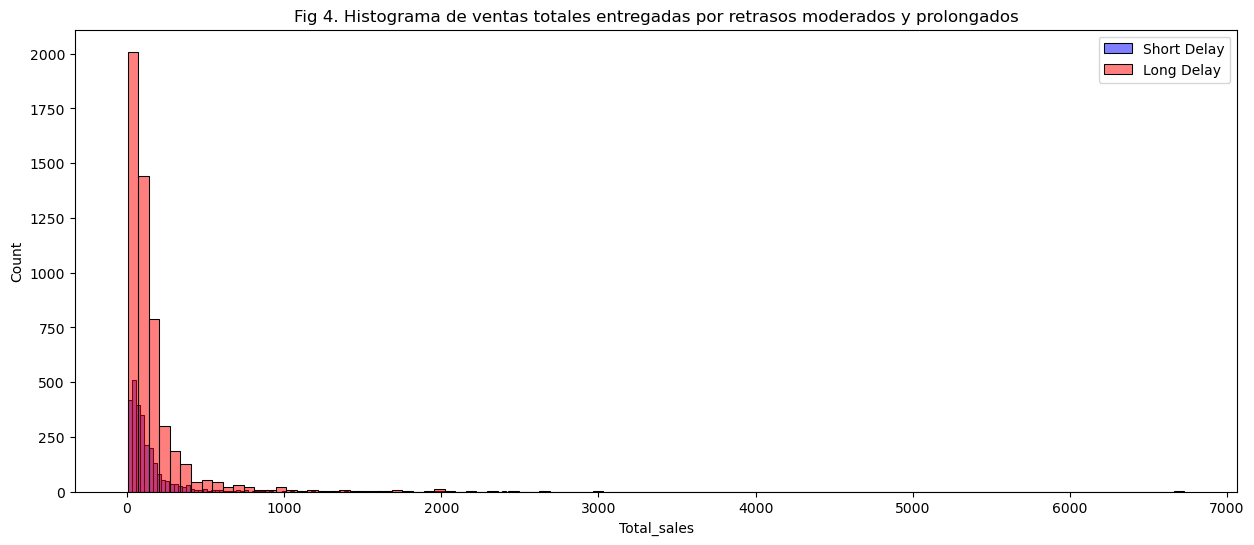

In [14]:
# Visualización que permite comparar los histogramas de las ventas de órdenes completas que tuvieron retrazos moderados y prolongados

# Especifica el tamaño de la figura
plt.figure(figsize = (15, 6))

# Filtra el DataFrame para órdenes con retrasos moderados
retraso_moderado = delivered[delivered['delay_status'] == 'short_delay']

# Filtra el DataFrame para órdenes con retrasos prolongados
retraso_prolongado = delivered[delivered['delay_status'] == 'long_delay']

# Crea el histograma para órdenes con retrasos moderados
sns.histplot(retraso_moderado['total_sales'], bins=100, alpha=0.5, label='Short Delay', color='blue')

# Crea el histograma para órdenes con retrasos prolongados
sns.histplot(retraso_prolongado['total_sales'], bins=100, alpha=0.5, label='Long Delay', color='red')

# Agrega etiquetas y título
plt.xlabel('Total_sales')
plt.ylabel('Count')
plt.title('Fig 4. Histograma de ventas totales entregadas por retrasos moderados y prolongados')

# Agrega una leyenda
plt.legend()

plt.savefig('3_a_histogram_sales_short_long_delays.png')